## 1. Import Libraries

In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


In [4]:
# 2. Load Dataset
file_path = 'Data/advertising.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [5]:
# 3. Data Preprocessing
# Check for missing values and basic statistics
data.info()
data.describe()

# Scaling the data to improve performance (standardize the data)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['TV', 'Radio', 'Newspaper']])
data[['TV', 'Radio', 'Newspaper']] = scaled_data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


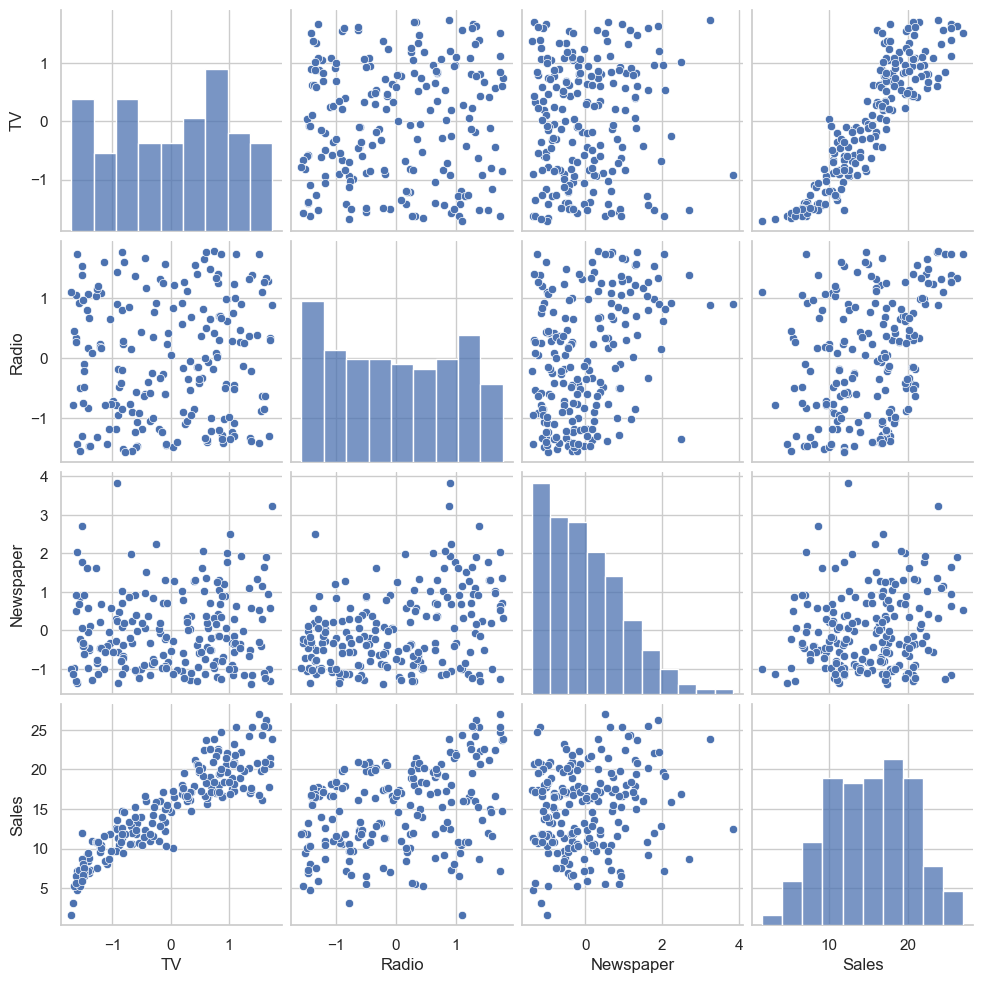

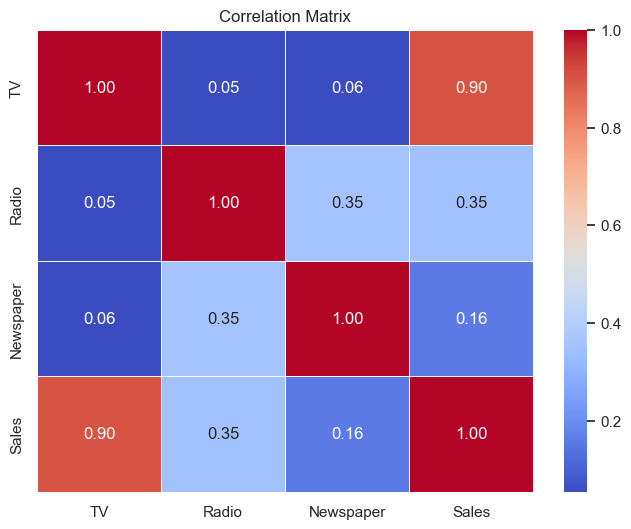

In [6]:
# 4. Exploratory Data Analysis (EDA)
sns.set(style="whitegrid")

# Create a pairplot to visualize relationships between the variables
sns.pairplot(data)
plt.show()

# Plot correlations between the features
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [7]:
# 5. Prepare Data for Model Training
# Splitting the data into features (X) and target (y)
X = data[['TV', 'Radio', 'Newspaper']]
y = data['Sales']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# 6. Train Multiple Models
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Store performance metrics
model_performance = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)  # Additional metric
    
    model_performance[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

# Display model performance
performance_df = pd.DataFrame(model_performance).T
performance_df


,MAE,MSE,RMSE,R²,MAPE
Linear Regression,1.274826,2.907757,1.705215,0.905901,0.108809
Decision Tree,1.240000,3.402000,1.844451,0.889907,0.114780
Random Forest,0.916225,1.436151,1.198395,0.953524,0.076207


In [9]:
# 7. Hyperparameter Tuning with GridSearchCV (for Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
grid_search.best_params_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [10]:
# 8. Cross-Validation (for a More Robust Evaluation)
cross_val_scores = {
    'Linear Regression': cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_absolute_error'),
    'Decision Tree': cross_val_score(DecisionTreeRegressor(random_state=42), X, y, cv=5, scoring='neg_mean_absolute_error'),
    'Random Forest': cross_val_score(RandomForestRegressor(random_state=42), X, y, cv=5, scoring='neg_mean_absolute_error')
}

# Display cross-validation results
cross_val_df = pd.DataFrame({name: scores.mean() for name, scores in cross_val_scores.items()}, index=['Mean MAE'])
cross_val_df


,Linear Regression,Decision Tree,Random Forest
Mean MAE,-1.268305,-1.1585,-0.914355


In [11]:
# 9. Evaluate the Best Model (Random Forest after GridSearchCV)
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best Random Forest model
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
mape_best_rf = mean_absolute_percentage_error(y_test, y_pred_best_rf)

print(f'Random Forest - MAE: {mae_best_rf}, MSE: {mse_best_rf}, RMSE: {rmse_best_rf}, R²: {r2_best_rf}, MAPE: {mape_best_rf}')


Random Forest - MAE: 0.9199509920634915, MSE: 1.4563654003469324, RMSE: 1.2067996521158482, R²: 0.9528701114087547, MAPE: 0.07643203715619826


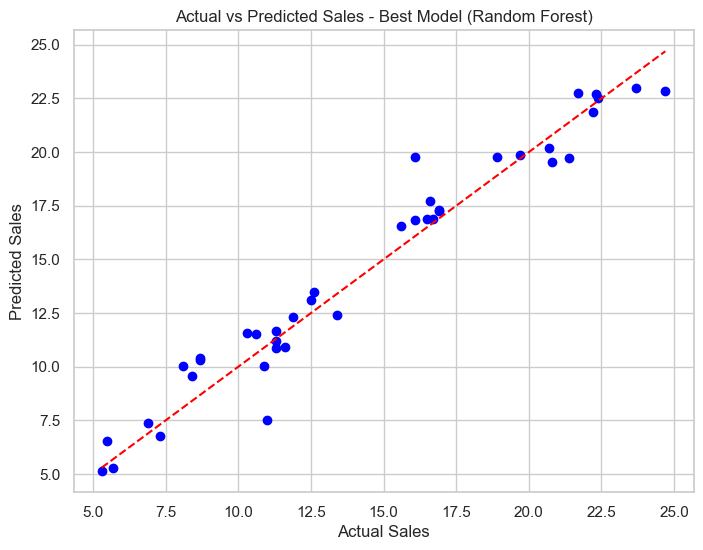

In [12]:
# 10. Visualize Actual vs Predicted Sales for the Best Model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best_rf, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales - Best Model (Random Forest)')
plt.show()


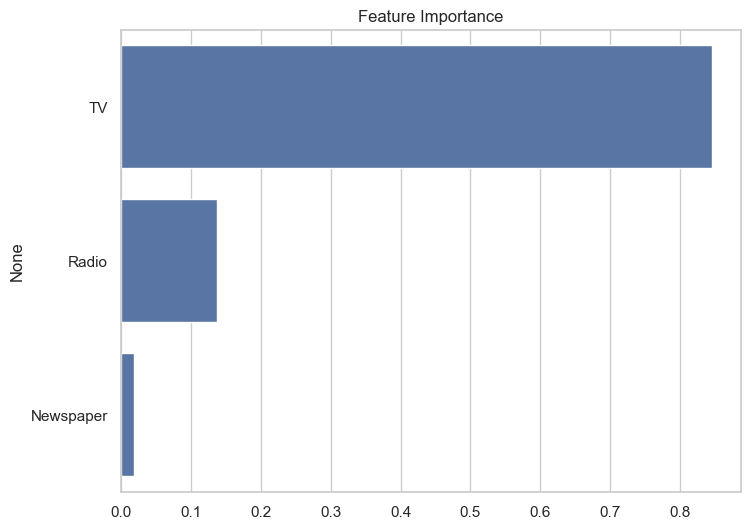

In [13]:
# 11. Feature Importance (for Random Forest)
features = X.columns
importances = best_rf.feature_importances_

# Visualizing feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=features, orient='h')
plt.title("Feature Importance")
plt.show()
